# LSTM Model for Bitcoin price prediction and a comparative study with Facebook Prophet.

# 1. Introduction

The journey of cryptocurrencies began with the launch of Bitcoin in 2009 by an unknown individual or group under the pseudonym Satoshi Nakamoto. This groundbreaking innovation introduced the world to the concept of a decentralized, peer-to-peer financial system, eliminating the need for intermediaries like banks. Following Bitcoin's success, numerous other cryptocurrencies emerged, each designed to address specific challenges or offer unique features. Today, leading cryptocurrencies by market capitalization include Bitcoin, Ethereum, and Binance Coin. Looking ahead, cryptocurrencies promise a future where decentralized financial systems could enhance financial inclusivity and potentially disrupt traditional economic structures, driving continuous innovation in blockchain technology and digital finance.

## 2. Some cryptocurrencies and a few minutes about them

In this section let us set the stage for the future chapters. We will download $\textbf{closing prices}$ of top 10 cryptocurrencies and see how they are performing over the years.

In [1]:
import yfinance as yf
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "browser"

In [2]:
crypto_tickers = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD',
                  'DOGE-USD', 'SOL-USD', 'DOT-USD', 'MATIC-USD', 'LTC-USD']

# Download data for each cryptocurrency
crypto_data = {}
for ticker in crypto_tickers:
    crypto_data[ticker] = yf.download(ticker, start='2014-01-01', end='2024-12-31')

# Build lists of Series for closing prices and volume with proper names
closing_series = []
volume_series = []
for crypto_ticker, data in crypto_data.items():
    close_series = data['Close']
    close_series.name = crypto_ticker  # set the series name for closing prices
    closing_series.append(close_series)

    vol_series = data['Volume']
    vol_series.name = crypto_ticker  # set the series name for volume
    volume_series.append(vol_series)

# Concatenate series into DataFrames
closing_data = pd.concat(closing_series, axis=1)
volume_data = pd.concat(volume_series, axis=1)

# Reset index so that the Date becomes a column
closing_data.reset_index(inplace=True)
volume_data.reset_index(inplace=True)

# Save DataFrames to CSV files
closing_data.to_csv('top_10_cryptocurrencies_closing.csv', index=False)
volume_data.to_csv('top_10_cryptocurrencies_volume.csv', index=False)

# Prepare data for table visualization
header_values = list(closing_data.columns)
cell_values = [closing_data[col].tail(10).tolist() for col in closing_data.columns]

# Create table figure using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=header_values, fill_color='paleturquoise', align='left'),
    cells=dict(values=cell_values, fill_color='lavender', align='left')
)])

fig.update_layout(autosize=False, width=1000, height=500)
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = 'colab'  # Set renderer to colab

fig.show()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


The box plot below provides a comparative analysis of the closing prices of the top 10 cryptocurrencies: Bitcoin (BTC), Ethereum (ETH), Binance Coin (BNB), XRP, Cardano (ADA), Dogecoin (DOGE), Solana (SOL), Polkadot (DOT), Polygon (MATIC), and Litecoin (LTC).

In the plot, each box shows the range within which the middle 50% of the closing prices for a cryptocurrency fall, known as the interquartile range (IQR). The line inside the box marks the median price. The "whiskers" extend to the smallest and largest prices within 1.5 times the IQR from the lower and upper quartiles. Any data points outside this range are considered outliers and are plotted individually.



In [3]:
# Create a long-form DataFrame for Plotly
closing_data_long = closing_data.melt(id_vars=['Date'], var_name='Cryptocurrency', value_name='Closing Price')
closing_data_long.head()
# Create a box plot
fig = px.box(closing_data_long, x='Cryptocurrency', y='Closing Price', title='Closing Prices of Top 10 Cryptocurrencies')
fig.show()

### Observations:
#### Bitcoin (BTC):
As expected, Bitcoin has the highest median closing price, reaffirming its status as the most valuable and widely recognized cryptocurrency.
#### Ethereum (ETH):
Following Bitcoin, Ethereum has the second-highest median price, underscoring its significant market presence and its utility in decentralized applications and smart contracts.
#### Binance Coin (BNB):
Binance Coin shows a relatively high median price, reflecting its strong association with the Binance exchange and its various uses within the Binance ecosystem.
#### Other Cryptocurrencies:
Cryptocurrencies like XRP, ADA, DOGE, SOL, DOT, MATIC, and LTC have lower median prices but show significant variation, indicating their volatile nature and varying market dynamics.

### Similarly for the volume

In [4]:
volume_data_long = volume_data.melt(id_vars=['Date'], var_name='Cryptocurrency', value_name='Volume')
fig_volume = px.box(volume_data_long, x='Cryptocurrency', y='Volume', title='Trading Volume of Top 10 Cryptocurrencies')
fig_volume.show()

In [5]:
fig = px.line(closing_data_long, x='Date', y='Closing Price', color='Cryptocurrency',
              title='Closing Prices of Top 10 Cryptocurrencies Over Time')

# Display the plot
fig.show()

# NB: Click on BTC-USD from the legends of the plot below to see the trends in other cryptocurrencies
# which are generally overshadowed by the Bitcoin.

## 3. Bitcoin

In this section we will manufacture an LSTM model to fit (and predict) the price of Bitcoin.

### 3.1 Importing the libraries

In [6]:
import yfinance as yf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
import os
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from prophet import Prophet
plt.style.use('ggplot')

### 3.2 Import the data from Yahoo Finance

[*********************100%***********************]  1 of 1 completed


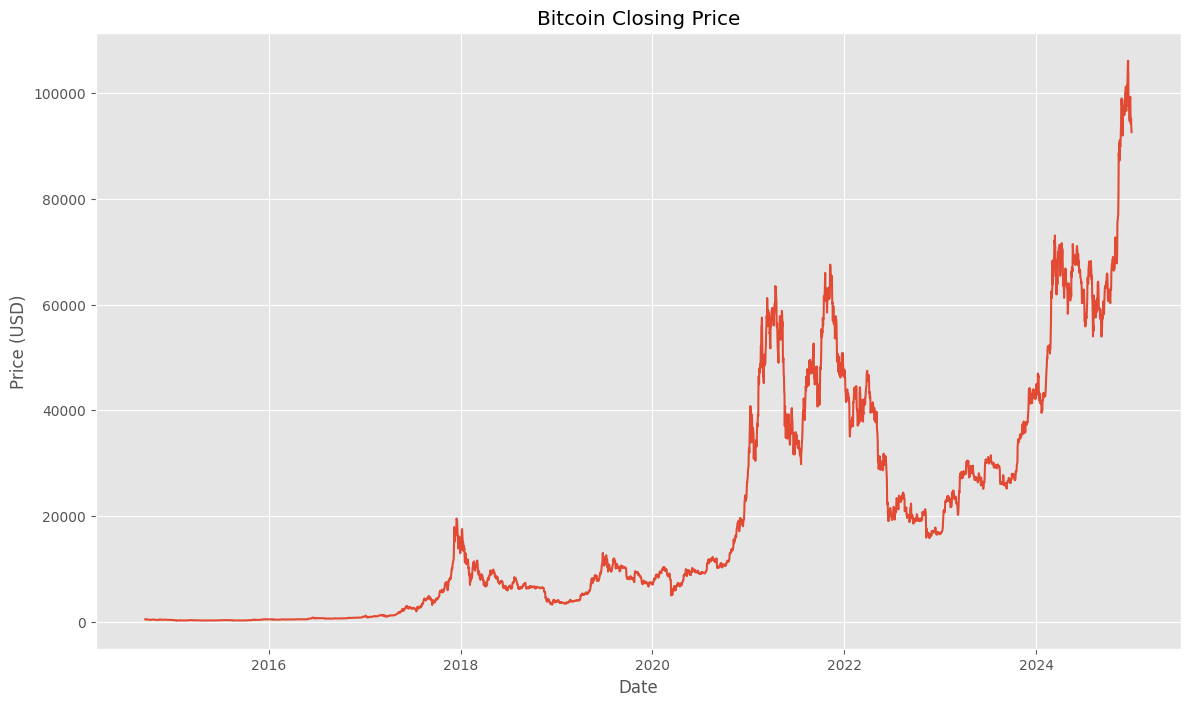

Price,Date,Close,High,Low,Open,Volume
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
3753,2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873
3754,2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565
3755,2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185
3756,2024-12-29,93530.226562,95174.875000,92881.789062,95174.054688,29635885267
3757,2024-12-30,92643.210938,94903.320312,91317.132812,93527.195312,56188003691


In [7]:
df = yf.download('BTC-USD', start='2014-01-01', end='2024-12-31')
df.reset_index(inplace=True)
plt.figure(figsize=(14, 8))
plt.plot(df['Date'], df['Close'])
plt.title('Bitcoin Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()
df.tail()

### 3.3 Prepare the data for LSTM

In [8]:
# Use the 'Close' price for the LSTM model
df2 = df['Close'].values
df2 = df2.reshape(-1, 1)

# Split the dataset into training and test sets
dataset_train = np.array(df2[:int(df.shape[0] * 0.8)])
dataset_test = np.array(df2[int(df2.shape[0] * 0.8) - 50:])
print(f"Train: {dataset_train.shape}, Test: {dataset_test.shape}")

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

# Function to create a dataset matrix
def create_my_dataset(df2):
    x = []
    y = []
    for i in range(50, df2.shape[0]):
        x.append(df2[i - 50:i, 0])
        y.append(df2[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x, y

# Create training and test datasets
x_train, y_train = create_my_dataset(dataset_train)
x_test, y_test = create_my_dataset(dataset_test)


Train: (3006, 1), Test: (802, 1)


### 3.4 Build & train the LSTM Model

In [9]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()

# Reshape the data for LSTM input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, epochs=50, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 329,857 (1.26 MB)

 Trainable params: 329,857 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0117
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0015
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.8756e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.3265e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0010
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.7740e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4252e-04
Epoch 13/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.4044e-04
Epoch 14/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.0158e-04
Epoch 15/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/

### 3.5 Prediction

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Test RMSE: 2307.727922168992


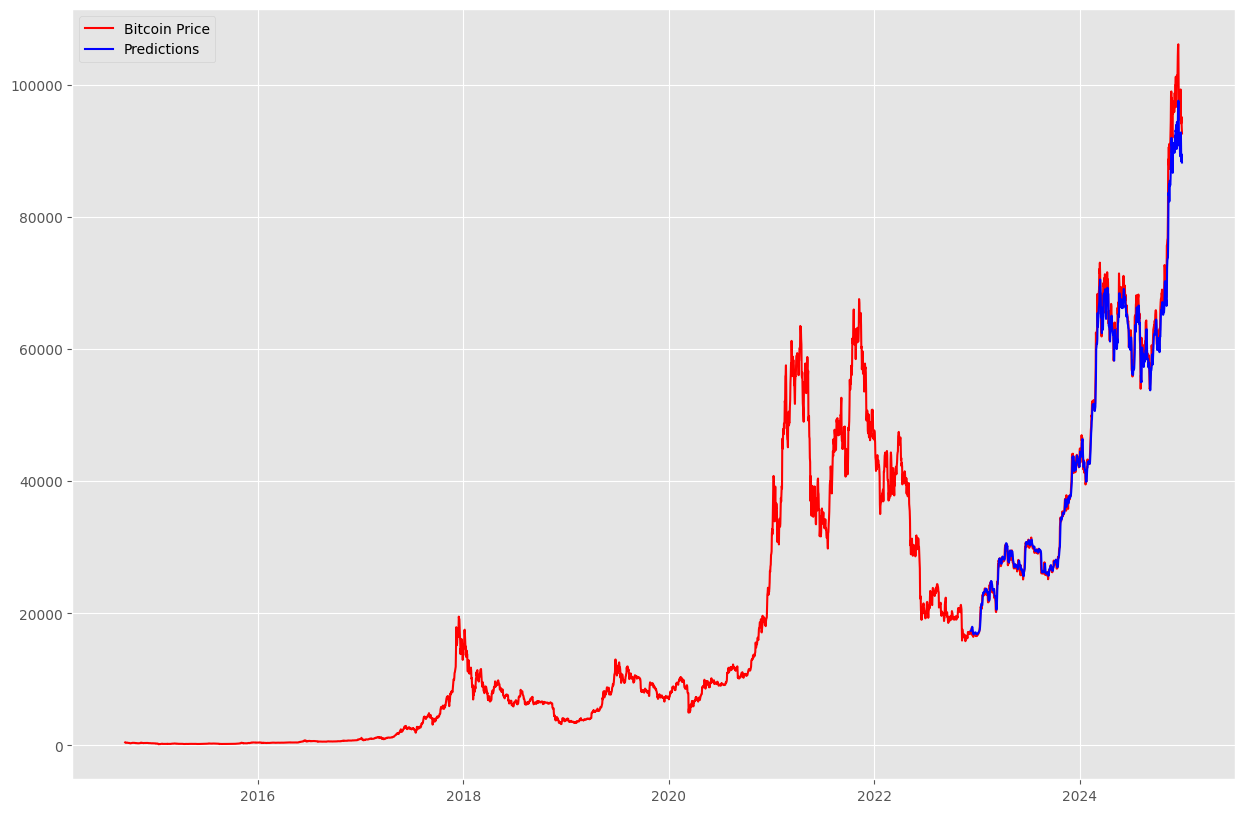

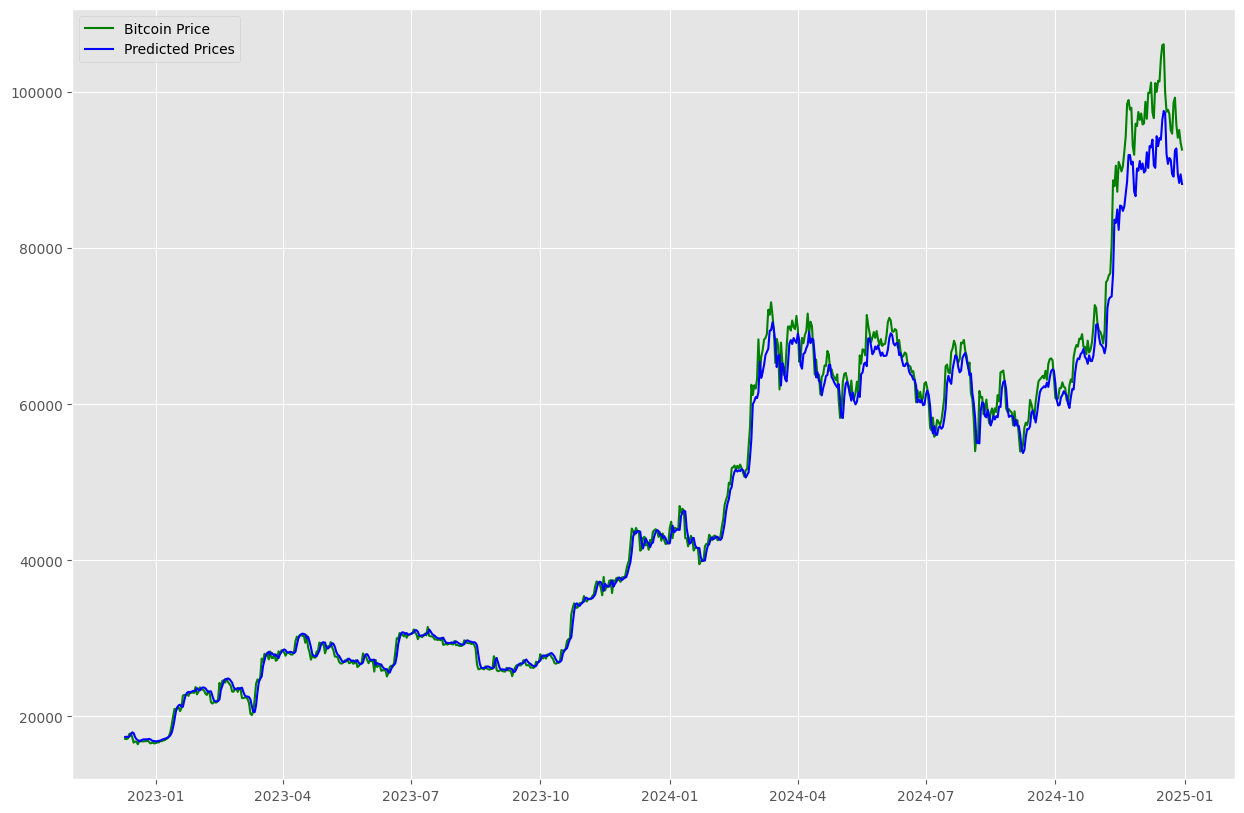

In [10]:
# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate RMSE
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions))
print(f'Test RMSE: {rmse}')

# Plot the results
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(df['Date'], df2, color='red', label='Bitcoin Price')
ax.plot(df['Date'][len(y_train) + 50:len(y_train) + 50 + len(predictions)], predictions, color='blue', label='Predictions')
plt.legend()

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df['Date'][len(y_train) + 50:len(y_train) + 50 + len(y_test_scaled)], y_test_scaled, color='green', label='Bitcoin Price')
plt.plot(df['Date'][len(y_train) + 50:len(y_train) + 50 + len(predictions)], predictions, color='blue', label='Predicted Prices')
plt.legend()

#### 3.5.1 Predict the next 10 days

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


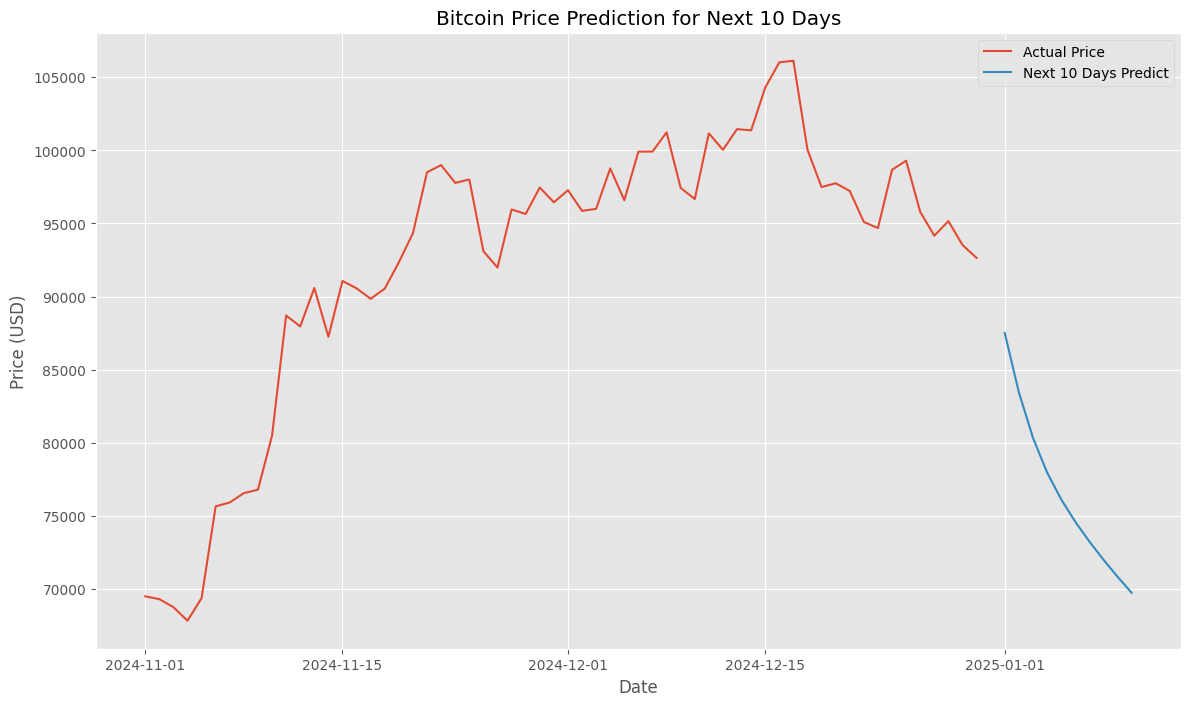

In [11]:
# Predict the next 10 days
last_60_days = dataset_test[-60:]
next_10_days = []

for _ in range(10):
    x_input = last_60_days[-50:].reshape(1, -1, 1)  # Ensure correct input shape
    next_day = model.predict(x_input)
    next_10_days.append(next_day)
    last_60_days = np.append(last_60_days[1:], next_day).reshape(-1, 1)  # Update and reshape

# Convert next_10_days to a 2D array before inverse transforming
next_10_days = np.array(next_10_days).reshape(-1, 1)
next_10_days = scaler.inverse_transform(next_10_days)

# Ensure future_dates and next_10_days have the same length
future_dates = pd.date_range(df['Date'].iloc[-1], periods=12, inclusive='right')[1:]

# Plot the predictions for the next 10 days
plt.figure(figsize=(14, 8))
plt.plot(df['Date'][-60:], df['Close'][-60:], label='Actual Price')
plt.plot(future_dates, next_10_days, label='Next 10 Days Predict')
plt.title('Bitcoin Price Prediction for Next 10 Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### 3.6 Prophet

Prophet is a forecasting tool developed by Facebook specifically for handling time series data that exhibit strong seasonal patterns and various types of anomalies. It's designed to be user-friendly, requiring minimal data preprocessing, and can provide accurate forecasts even with missing data points or outliers. Prophet works well for daily, weekly, and yearly seasonality and includes built-in holiday effects, making it a robust choice for business and economic data analysis. Its intuitive model and ease of use make it accessible for both novice and experienced analysts, allowing them to generate reliable forecasts with just a few lines of code.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm1jzut8p/6bs1fpfh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm1jzut8p/jxaomyid.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97899', 'data', 'file=/tmp/tmpm1jzut8p/6bs1fpfh.json', 'init=/tmp/tmpm1jzut8p/jxaomyid.json', 'output', 'file=/tmp/tmpm1jzut8p/prophet_modeldj5hu293/prophet_model-20250322203736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:37:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:37:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


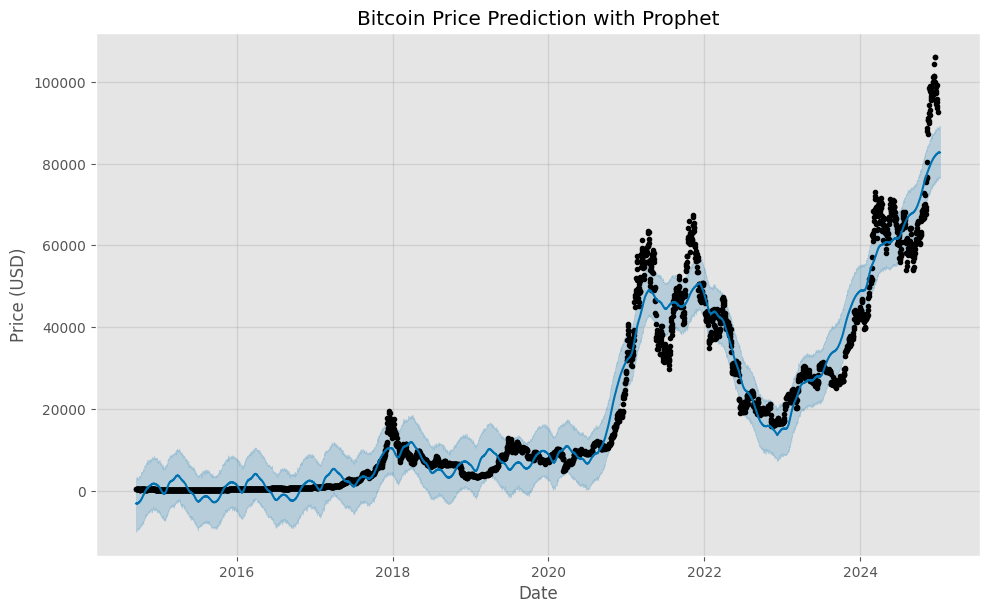

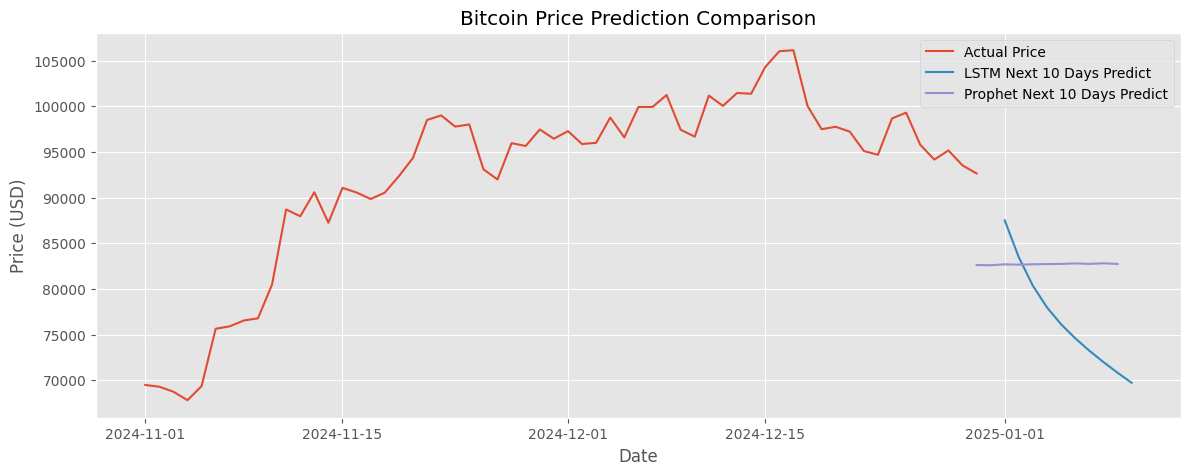

LSTM RMSE for Next 10 Days: 19665.966541210222
Prophet RMSE for Next 10 Days: 13089.750371431533


In [12]:
# Prepare the data for Prophet
prophet_data = df[['Date', 'Close']]
prophet_data.columns = ['ds', 'y']

# Initialize and fit the model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Make future dataframe for 10 days
future = prophet_model.make_future_dataframe(periods=10)
forecast = prophet_model.predict(future)

# Plot Prophet's predictions
fig = prophet_model.plot(forecast)
plt.title('Bitcoin Price Prediction with Prophet')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

# Extract predicted values
prophet_pred = forecast[['ds', 'yhat']].set_index('ds')
prophet_pred = prophet_pred.loc[df['Date'].iloc[-1]:]

# Compare Prophet and LSTM predictions
plt.figure(figsize=(14, 5))
plt.plot(df['Date'][-60:], df['Close'][-60:], label='Actual Price')
plt.plot(future_dates, next_10_days, label='LSTM Next 10 Days Predict')
plt.plot(prophet_pred.index, prophet_pred['yhat'], label='Prophet Next 10 Days Predict')
plt.title('Bitcoin Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Comparative analysis
lstm_rmse = np.sqrt(mean_squared_error(df['Close'][-10:], next_10_days))
prophet_rmse = np.sqrt(mean_squared_error(df['Close'][-10:], prophet_pred['yhat'][:10]))

print(f'LSTM RMSE for Next 10 Days: {lstm_rmse}')
print(f'Prophet RMSE for Next 10 Days: {prophet_rmse}')


$\textbf{Observations}$

$\textbf{1. LSTM Predictions:}$

The LSTM model predicts a significant downward trend in Bitcoin prices over the next 30 days.
This suggests that the model is highly sensitive to recent downward movements in the training data, projecting them into the future.

$\textbf{2. Prophet Predictions:}$

The Prophet model predicts a relatively stable trend with minor fluctuations.
This indicates that Prophet is less influenced by recent volatility and tends to smooth out the forecasts, considering seasonal and trend components over a longer historical period.

$\textbf{3. Comparison with Actual Prices:}$


The actual Bitcoin prices in the last 60 days show considerable fluctuation, reflecting the inherent volatility of cryptocurrency markets.
Both models capture different aspects of the trend: LSTM is more reactive to recent changes, while Prophet provides a more generalized trend.

$\textbf{4. Model Performance:}$

The RMSE values indicate that while LSTM captures the immediate price movements better (lower RMSE), it might be overfitting to recent trends.
Prophet's higher RMSE suggests that its general trend prediction might not align well with the short-term movements but is possibly more robust for long-term forecasting.

$\textbf{Analysis}$

$\textbf{LSTM's Sensitivity:}$
The LSTM model's sensitivity to recent data makes it suitable for short-term predictions where recent trends are crucial. However, this sensitivity can lead to drastic predictions if the recent past is highly volatile, as seen here.

$\textbf{Prophet's Stability:}$
The Prophet model's approach of considering longer-term seasonality and trend components makes it less responsive to short-term fluctuations. This stability can be advantageous for forecasting longer-term trends but may not capture immediate market movements accurately.

$\textbf{Volatility of Bitcoin:}$
The inherent volatility of Bitcoin presents challenges for both models. The significant differences in their forecasts highlight the uncertainty and complexity of predicting cryptocurrency prices.